In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils,datasets, models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import tqdm
import glob
# Ignore warnings
import time
import copy
import warnings
warnings.filterwarnings("ignore")
import math
plt.ion()   # interactive mode
import re
import tensorflow as tf
import torchvision.transforms.functional as F

### Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
!ls "/content/drive/My Drive/Ydata/CellCounting/images"

In [ ]:
io.imshow(io.imread("/content/drive/My Drive/Ydata/CellCounting/images/001cell.png"))



In [ ]:
images=[]
imagesnames=[]



for filename in glob.glob('//content/drive/My Drive/Ydata/CellCounting/images/*.png'):
  img=io.imread(filename)
  images.append(np.float32(img))
  i=re.findall(r'\d+', filename)[0]
  imagesnames.append(int(i))



imagedict=dict(zip(imagesnames,images))

labels=[]
labelsnames=[]

for filename in glob.glob('//content/drive/My Drive/Ydata/CellCounting/labels/*.png'):
  img=io.imread(filename)
  labels.append(int(img.sum()/255))
  i=re.findall(r'\d+', filename)[0]
  labelsnames.append(int(i))

labelsdict=dict(zip(labelsnames,labels))

In [ ]:
plt.imshow(imagedict[imagesnames[0]]),print(labelsdict[imagesnames[0]])

In [ ]:
len(imagedict)

In [ ]:
plt.hist(np.array(labels),bins=100)
plt.show()

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [ ]:
images_train=[imagedict[k]/255 for k in range(1,181)]
images_test=[imagedict[k]/255 for k in range(181,200)]
labels_train=[labelsdict[k] for k in range(1,181)]
labels_test=[labelsdict[k] for k in range(181,200)]

images_train=torch.tensor(np.array(images_train),dtype=torch.float32).permute(0, 3, 1, 2) #sample, channel, width, hieght
images_test=torch.tensor(np.array(images_test),dtype=torch.float32).permute(0, 3, 1, 2) #sample, channel, width, hieght

# Define transformations that resize the images to 256x256, and normalize them.
# The means and standard deviations of each channel are the values used for normalization in ImageNet
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

image_datasets = {'train': CustomDataset(images_train, labels_train), #, transform=data_transforms),
                  'val': CustomDataset(images_test, labels_test)} #, transform=data_transforms)}


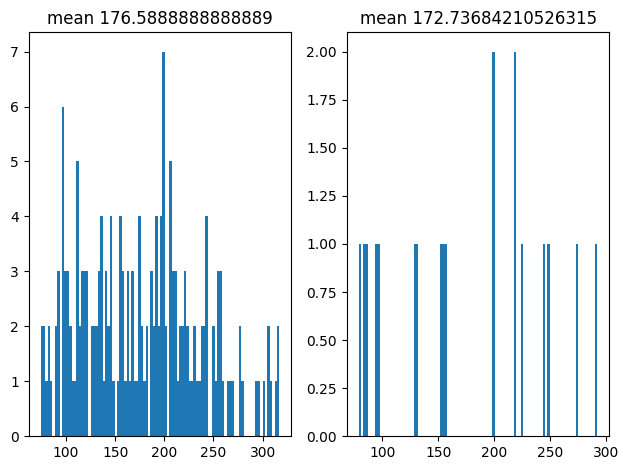

In [ ]:
plt.subplot(1,2,1)
plt.hist(np.array(labels_train),bins=100)
plt.title(f'mean {np.array(labels_train).mean()}')
plt.subplot(1,2,2)
plt.hist(np.array(labels_test),bins=100)
plt.title(f'mean {np.array(labels_test).mean()}')
plt.tight_layout()
plt.show()
print()

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


### Run Models

Ultimately we learned this model is unnecesarily large!

In [ ]:

# Define the model
modelOG = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64 ,32, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),


            nn.Flatten(),
            nn.Linear(32768,200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.ReLU(),
            nn.Linear(50,1)
        )


In [ ]:
def train_model(model, dataloader, criterion, optimizer, scheduler,num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000000.0

    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0

            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                X_batch = inputs.to(device)#,dtype='float32')
                y_batch = labels.to(device)#,dtype='float32')


                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(X_batch) #
                    loss = criterion(outputs, y_batch)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * X_batch.size(0)

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

            dict_res[phase][0,epoch]=epoch_loss

            # Keep the results of the best model so far
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val MAE: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    plt.plot(dict_res['train'][0])
    plt.plot(dict_res['val'][0])
    plt.title('Loss')
    plt.legend(['train','val'])
    plt.ylim(0,150)
    plt.show()

    return model, dict_res, best_loss


Epoch 0/9
----------
train Loss: 57.7276
val Loss: 22.3684
Epoch 1/9
----------
train Loss: 33.7276
val Loss: 59.3672
Epoch 2/9
----------
train Loss: 32.4577
val Loss: 61.3304
Epoch 3/9
----------
train Loss: 29.6399
val Loss: 11.5501
Epoch 4/9
----------
train Loss: 16.2008
val Loss: 36.5270
Epoch 5/9
----------
train Loss: 17.9375
val Loss: 10.6815
Epoch 6/9
----------
train Loss: 17.0813
val Loss: 7.8503
Epoch 7/9
----------
train Loss: 6.7680
val Loss: 7.3338
Epoch 8/9
----------
train Loss: 8.5974
val Loss: 6.7763
Epoch 9/9
----------
train Loss: 6.3150
val Loss: 6.7010
Training complete in 0m 39s
Best val MAE: 6.700967


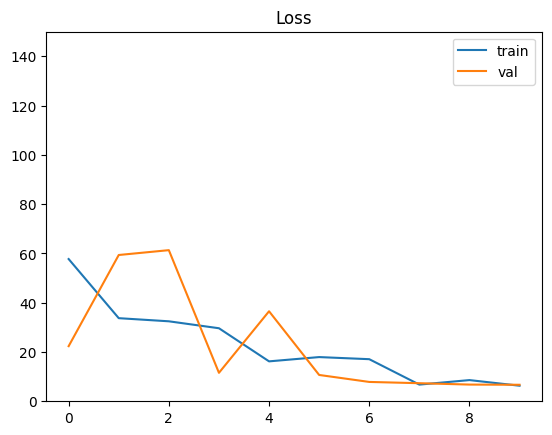

In [ ]:
batchsize=1

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batchsize,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batchsize,
                                          shuffle=False, num_workers=4)
  }

model=copy.deepcopy(modelOG)
model=model.to(device)


criterion = nn.L1Loss() #MAE

optimizer_ft =  optim.Adam(model.parameters(), lr=0.001) #optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

model,dict_res,MAE = train_model(model,#.to('cuda'),
                       dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

### try augmentation

In [ ]:
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

image_datasets = {'train': CustomDataset(images_train, labels_train), #, transform=data_transforms),
                  'val': CustomDataset(images_test, labels_test)} #, transform=data_transforms)}


Epoch 0/9
----------
train Loss: 69.2063
val Loss: 123.0056
Epoch 1/9
----------
train Loss: 34.0389
val Loss: 44.0592
Epoch 2/9
----------
train Loss: 23.1621
val Loss: 18.1461
Epoch 3/9
----------
train Loss: 33.0061
val Loss: 16.0849
Epoch 4/9
----------
train Loss: 31.4842
val Loss: 23.1589
Epoch 5/9
----------
train Loss: 22.1398
val Loss: 15.5451
Epoch 6/9
----------
train Loss: 22.2128
val Loss: 16.8865
Epoch 7/9
----------
train Loss: 7.5917
val Loss: 7.9871
Epoch 8/9
----------
train Loss: 6.8311
val Loss: 7.8026
Epoch 9/9
----------
train Loss: 8.1568
val Loss: 8.7753
Training complete in 0m 33s
Best val MAE: 7.802551


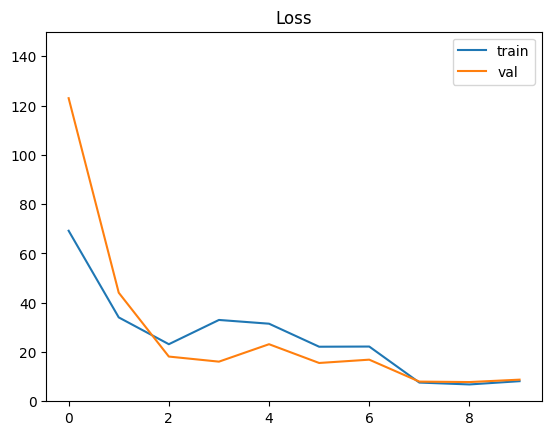

In [ ]:
batchsize=1

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batchsize,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batchsize,
                                          shuffle=False, num_workers=4)
  }

model=copy.deepcopy(modelOG)
model=model.to(device)


criterion = nn.L1Loss() #MAE

optimizer_ft =  optim.Adam(model.parameters(), lr=0.001) #optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

model,dict_res,MAE = train_model(model,#.to('cuda'),
                       dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

### batch size

Epoch 0/9
----------
train Loss: 117.5929
val Loss: 63.7809
Epoch 1/9
----------
train Loss: 57.4669
val Loss: 60.1130
Epoch 2/9
----------
train Loss: 55.0955
val Loss: 59.6696
Epoch 3/9
----------
train Loss: 54.3763
val Loss: 59.5301
Epoch 4/9
----------
train Loss: 51.7057
val Loss: 93.1318
Epoch 5/9
----------
train Loss: 65.1701
val Loss: 67.2414
Epoch 6/9
----------
train Loss: 56.5194
val Loss: 61.1618
Epoch 7/9
----------
train Loss: 53.1420
val Loss: 58.7366
Epoch 8/9
----------
train Loss: 50.7826
val Loss: 59.6192
Epoch 9/9
----------
train Loss: 51.6925
val Loss: 59.2152
Training complete in 0m 24s
Best val MAE: 58.736619


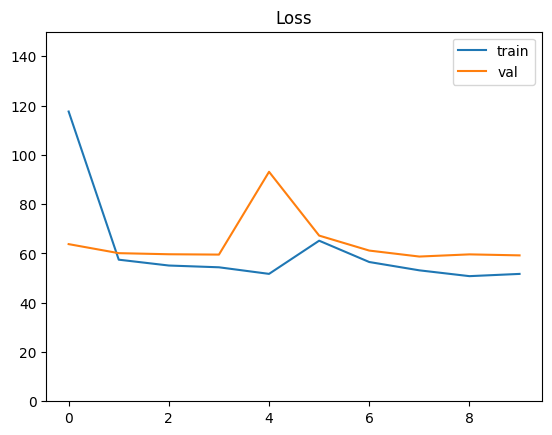

In [ ]:
batchsize=16

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batchsize,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batchsize,
                                          shuffle=False, num_workers=4)
  }

model=copy.deepcopy(modelOG)
model=model.to(device)


criterion = nn.L1Loss() #MAE

optimizer_ft =  optim.Adam(model.parameters(), lr=0.001) #optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

model,dict_res,MAE = train_model(model,#.to('cuda'),
                       dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

### adjust sharpness augmentation

Epoch 0/14
----------
train Loss: 62.9059
val Loss: 24.6554
Epoch 1/14
----------
train Loss: 33.1158
val Loss: 91.3351
Epoch 2/14
----------
train Loss: 21.6124
val Loss: 52.2868
Epoch 3/14
----------
train Loss: 20.1256
val Loss: 15.2471
Epoch 4/14
----------
train Loss: 19.0049
val Loss: 10.5484
Epoch 5/14
----------
train Loss: 19.8437
val Loss: 15.8196
Epoch 6/14
----------
train Loss: 20.8839
val Loss: 18.6605
Epoch 7/14
----------
train Loss: 7.5566
val Loss: 7.5342
Epoch 8/14
----------
train Loss: 7.2160
val Loss: 8.6225
Epoch 9/14
----------
train Loss: 7.3579
val Loss: 10.6893
Epoch 10/14
----------
train Loss: 6.9433
val Loss: 11.6404
Epoch 11/14
----------
train Loss: 6.5797
val Loss: 6.5288
Epoch 12/14
----------
train Loss: 6.8087
val Loss: 8.0717
Epoch 13/14
----------
train Loss: 6.4271
val Loss: 5.8930
Epoch 14/14
----------
train Loss: 4.8821
val Loss: 6.7723
Training complete in 0m 52s
Best val MAE: 5.892988


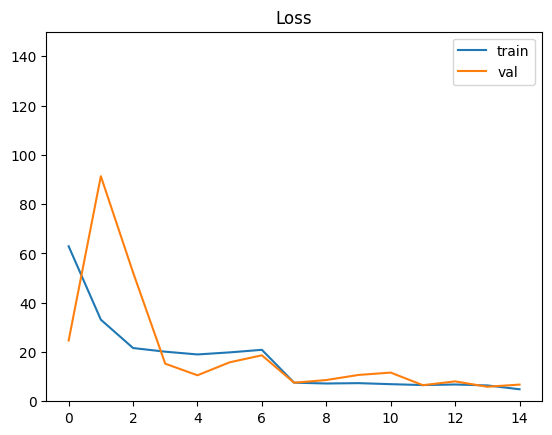

In [ ]:
batchsize=1

torch.manual_seed(42)

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
        transforms.ColorJitter(),
        transforms.RandomAdjustSharpness(sharpness_factor=.5)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
        transforms.ColorJitter(),
        transforms.RandomAdjustSharpness(sharpness_factor=.5)

    ]),
}

image_datasets = {'train': CustomDataset(images_train, labels_train), #, transform=data_transforms),
                  'val': CustomDataset(images_test, labels_test)} #, transform=data_transforms)}



dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batchsize,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batchsize,
                                          shuffle=False, num_workers=4)
  }

model=copy.deepcopy(modelOG)
model=model.to(device)


criterion = nn.L1Loss() #MAE

optimizer_ft =  optim.Adam(model.parameters(), lr=0.001) #optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 15

model,dict_res,MAE = train_model(model,#.to('cuda'),
                       dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

### optimizer

In [ ]:
batchsize=1

torch.manual_seed(42)

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
        transforms.ColorJitter(),
        transforms.RandomAdjustSharpness(sharpness_factor=.5)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
        transforms.ColorJitter(),
        transforms.RandomAdjustSharpness(sharpness_factor=.5)

    ]),
}

image_datasets = {'train': CustomDataset(images_train, labels_train), #, transform=data_transforms),
                  'val': CustomDataset(images_test, labels_test)} #, transform=data_transforms)}



dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batchsize,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batchsize,
                                          shuffle=False, num_workers=4)
  }

model=copy.deepcopy(modelOG)
model=model.to(device)


criterion = nn.L1Loss() #MAE

optimizer_ft =  optim.SGD(model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 15

model,dict_res,MAE = train_model(model,#.to('cuda'),
                       dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 176.4703
val Loss: 172.6021
Epoch 1/14
----------
train Loss: 176.4384
val Loss: 172.5704
Epoch 2/14
----------
train Loss: 176.4067
val Loss: 172.5387
Epoch 3/14
----------
train Loss: 176.3748
val Loss: 172.5063
Epoch 4/14
----------
train Loss: 176.3418
val Loss: 172.4730
Epoch 5/14
----------
train Loss: 176.3096
val Loss: 172.4426
Epoch 6/14
----------
train Loss: 176.2799
val Loss: 172.4128
Epoch 7/14
----------


### error analysis

Checking to see if there have specific problem areas

In [ ]:
batchsize=1

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batchsize,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batchsize,
                                          shuffle=False, num_workers=4)
  }

y_pred=[]
y_true=[]

for input, y in dataloaders['val']:
  input = input[0:1]
  y = y[0:1]
  pred=model(input.float().to(device))
  y_pred.append(pred[0][0])
  y_true.append(y.cpu())



In [ ]:
y_pred1=[np.array(k.detach().cpu()) for k in y_pred]


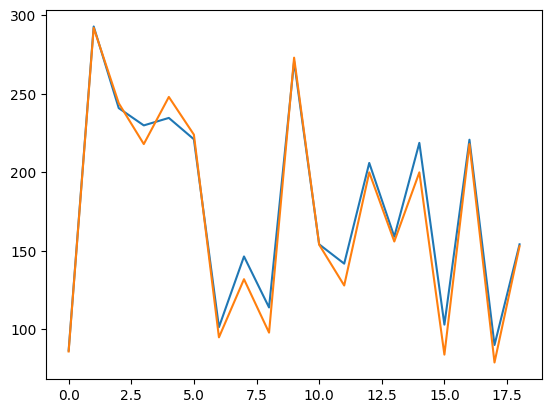

In [ ]:
plt.plot(y_pred1)
plt.plot(y_true)

In most cases we are undercounting. Perhaps sharpness augmentation is work playing with.